## Function-Calling (Tool Use) with Converse API in Amazon Bedrock

In this example notebook, we'll explore how to perform Function-Calling through the use of Tools with the Converse API for Amazon Bedrock.

The Converse or ConverseStream API is a unified structured text action for simplifying the invocations to Bedrock LLMs. It includes the possibility to define tools for implementing external functions that can be called or triggered from the LLMs.

Let's start by installing a few requirements for running this example. We only need to run this cell the first time.

In [1]:
!pip3 install -qU boto3
!pip3 install -qU googlesearch-python lxml

We can now import the relevant libraries.

In [1]:
import boto3
import json, sys
from datetime import datetime

print('Running boto3 version:', boto3.__version__)

Running boto3 version: 1.34.118


Let's also define a few variables. Make sure to adjust these parameters according to your needs.

In [2]:
modelId = 'anthropic.claude-3-sonnet-20240229-v1:0'
#modelId = 'anthropic.claude-3-haiku-20240307-v1:0'
#modelId = 'cohere.command-r-plus-v1:0'
#modelId = 'cohere.command-r-v1:0'
#modelId = 'mistral.mistral-large-2402-v1:0'
print(f'Using modelId: {modelId}')

region = 'us-east-1'
print('Using region: ', region)

bedrock = boto3.client(
    service_name = 'bedrock-runtime',
    region_name = region,
    )

Using modelId: anthropic.claude-3-sonnet-20240229-v1:0
Using region:  us-east-1


### 1. Basic tool function-calling

We're now ready to define our tools through Python functions.

In our example, we will define a tool for simulating a weather forecast lookup tool (get_weather). Note in our example we're just returning a constant weather forecast to illustrate the concept, but you could make it fully functional by connecting any weather service API.

In [3]:
class ToolsList:
    #Define our get_weather tool function...
    def get_weather(self, city, state):
        #print(city, state)
        result = f'Weather in {city}, {state} is 70F and clear skies.'
        print(f'Tool result: {result}')
        return result

Let's structure our tools configuration for passing this information to our Converse API later. We have to clearly define the schema that our tools are expecting in the corresponding functions.

Note that we can also define specific configurations such as the tool choice, which allow us to either let the LLM choose automatically (auto), or overriding a fixed tool to be called always. You can check more information on this parameter in the Bedrock Converse API documentation.

In [4]:
#Define the configuration for our tool...
toolConfig = {'tools': [],
'toolChoice': {
    'auto': {},
    #'any': {},
    #'tool': {
    #    'name': 'get_weather'
    #}
    }
}

toolConfig['tools'].append({
        'toolSpec': {
            'name': 'get_weather',
            'description': 'Get weather of a location.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'city': {
                            'type': 'string',
                            'description': 'City of the location'
                        },
                        'state': {
                            'type': 'string',
                            'description': 'State of the location'
                        }
                    },
                    'required': ['city', 'state']
                }
            }
        }
    })

Let's define a handy function for calling Bedrock with the Converse API.

In [5]:
#Function for caling the Bedrock Converse API...
def converse_with_tools(messages, system='', toolConfig=toolConfig):
    response = bedrock.converse(
        modelId=modelId,
        system=system,
        messages=messages,
        toolConfig=toolConfig
    )
    return response

We're now ready for setting up our orchestration flow. In this case, we'll make a first call to the LLM with the initial prompt from the user, and depending on the answer from the LLM we'll either call a tool (function calling) or end the interaction.

Note that in the case the LLM indicates that it wants to run a tool (function calling), it will give us the information required of tool name and arguments for us to run the relevant tool in our code; i.e. The LLMs cannot run the tools automatically.

In [14]:
#Function for orchestrating the conversation flow...
def converse(prompt, system=''):
    #Add the initial prompt:
    messages = []
    messages.append(
        {
            "role": "user",
            "content": [
                {
                    "text": prompt
                }
            ]
        }
    )
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Initial prompt:\n{json.dumps(messages, indent=2)}")

    #Invoke the model the first time:
    output = converse_with_tools(messages, system)
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Output so far:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}")

    #Add the intermediate output to the prompt:
    messages.append(output['output']['message'])

    function_calling = next((c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c), None)

    #Check if function calling is triggered:
    if function_calling:
        #Get the tool name and arguments:
        tool_name = function_calling['name']
        tool_args = function_calling['input'] or {}
        
        #Run the tool:
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Running ({tool_name}) tool...")
        tool_response = getattr(ToolsList(), tool_name)(**tool_args) or ""
        if tool_response:
            tool_status = 'success'
        else:
            tool_status = 'error'

        #Add the tool result to the prompt:
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        'toolResult': {
                            'toolUseId':function_calling['toolUseId'],
                            'content': [
                                {
                                    "text": tool_response
                                }
                            ],
                            'status': tool_status
                        }
                    }
                ]
            }
        )
        #print(f"\n{datetime.now().strftime('%H:%M:%S')} - Messages so far:\n{json.dumps(messages, indent=2)}")

        #Invoke the model one more time:
        output = converse_with_tools(messages, system)
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Final output:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}\n")
    return

Now, we have everything setup and are ready for testing our function-calling bot.

Let's try with a few sample prompts, each one with different needs.

In [15]:
prompts = [
    "What is the weather like in Queens, NY?",
    "What is the capital of France?"
]

for prompt in prompts:
    converse(
        system = [{"text": "You're provided with a tool that can get the weather information for a specific locations 'get_weather'; \
            only use the tool if required. Don't make reference to the tools in your final answer."}],
        prompt = prompt
)


12:26:13 - Initial prompt:
[
  {
    "role": "user",
    "content": [
      {
        "text": "What is the weather like in Queens, NY?"
      }
    ]
  }
]

12:26:15 - Output so far:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "toolUse": {
          "toolUseId": "tooluse_MVJ6Ndd_TieMUfBpu8_Kww",
          "name": "get_weather",
          "input": {
            "city": "Queens",
            "state": "NY"
          }
        }
      }
    ]
  }
}

12:26:15 - Running (get_weather) tool...
Tool result: Weather in Queens, NY is 70F and clear skies.

12:26:18 - Final output:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "text": "According to the weather information provided, the current weather in Queens, NY is 70°F (around 21°C) and clear skies. This indicates pleasant, sunny conditions with warm temperatures typical for spring or summer in that area."
      }
    ]
  }
}


12:26:18 - Initial prompt:
[
  {
    "role": "user",
    

As we can see, the LLM decides whether or not to call the get_weather tool depending on the question.

You can further improve this example by playing with the system prompts. Also, you might want to switch the LLM and explore the differences.

Note that the Bedrock Converse API allow us to seamlessly use the same code and structure for working with multiple model providers. No changes are needed in the syntax of our interaction.

### 2. Basic tool function-calling, with image result

Let's now explore a case where our get_weather tool is not only returning a text, but now also returns an image.

For this, we will simulate that our tool is returning a complex visual forecast like the sample image below.

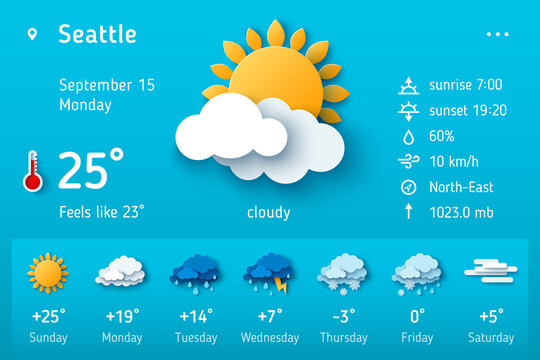

In [9]:
from IPython.display import Image
Image(filename='./images/weather.jpg') 

In [10]:
class ToolsList2:
    #Define our get_weather tool function...
    def get_weather(self, city, state):
        #print(city, state)
        result = f'Weather in {city}, {state} is 70F and clear skies.'
        with open('./images/weather.jpg', "rb") as image_file:
            binary_data = image_file.read()
        return result, binary_data

In [11]:
#Define the configuration for our tool...
toolConfig = {'tools': [],
'toolChoice': {
    'auto': {},
    #'any': {},
    #'tool': {
    #    'name': 'get_weather'
    #}
    }
}

toolConfig['tools'].append({
        'toolSpec': {
            'name': 'get_weather',
            'description': 'Get weather of a location.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'city': {
                            'type': 'string',
                            'description': 'City of the location'
                        },
                        'state': {
                            'type': 'string',
                            'description': 'State of the location'
                        }
                    },
                    'required': ['city', 'state']
                }
            }
        }
    })

In [26]:
#Function for orchestrating the conversation flow...
def converse_image(prompt, system=''):
    #Add the initial prompt:
    messages = []
    messages.append(
        {
            "role": "user",
            "content": [
                {
                    "text": prompt
                }
            ]
        }
    )
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Initial prompt:\n{json.dumps(messages, indent=2)}")

    #Invoke the model the first time:
    output = converse_with_tools(messages, system)
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Output so far:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}")

    #Add the intermediate output to the prompt:
    messages.append(output['output']['message'])

    function_calling = next((c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c), None)

    #Check if function calling is triggered:
    if function_calling:
        #Get the tool name and arguments:
        tool_name = function_calling['name']
        tool_args = function_calling['input'] or {}
        
        #Run the tool:
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Running ({tool_name}) tool...")
        tool_response, tool_response_image = getattr(ToolsList2(), tool_name)(**tool_args)

        #Add the tool result to the prompt:
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        'toolResult': {
                            'toolUseId':function_calling['toolUseId'],
                            'content': [
                                {
                                    "text": tool_response
                                },
                                {
                                    "image": {
                                        "format": "jpeg",
                                        "source":  {
                                            "bytes": tool_response_image,
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ]
            }
        )

        #Invoke the model one more time:
        output = converse_with_tools(messages, system)
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Final output:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}\n")
    return

In [27]:
prompts = [
    "What is the weather like in Seattle?",
]

for prompt in prompts:
    converse_image(
        system = [{"text": "You're provided with a tool that can get the weather information for a specific locations called 'get_weather'; \
            only use this tool if required. Don't make reference to the tools in your final answer."}],
        prompt = prompt
)


08:51:57 - Initial prompt:
[
  {
    "role": "user",
    "content": [
      {
        "text": "What is the weather like in Seattle?"
      }
    ]
  }
]

08:51:59 - Output so far:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "toolUse": {
          "toolUseId": "tooluse_YxfqHWfXREqOkNvLbR7kAg",
          "name": "get_weather",
          "input": {
            "city": "Seattle",
            "state": "Washington"
          }
        }
      }
    ]
  }
}

08:51:59 - Running (get_weather) tool...

08:52:03 - Final output:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "text": "Based on the weather information provided, it looks like Seattle is enjoying pleasant late summer weather today. The temperature is a mild 70°F (around 25°C) with clear, sunny skies overhead. The weather graphic shows a cheerful sun icon indicating the sunny conditions. It seems like ideal weather to spend some time outdoors and soak up the last of the summer

As we can see, the model is now considering both the text and image returned by our get_weather tool for providing its final answer.

You can play with the system and user prompts for experimenting other scenarios.

### 3. Multi-tool choice function-calling

Finally, let's explore the case where we not only have a get_weather tool, but now also have a fully functional web_search tool that can look up information in the Internet for enriching our responses.

For this, we'll leverage a public library with a simple web scrapping implementation. You might to adjust this example for using an API-key based library for improved efficiency in the web search, but this is out of the scope of this example.

In [15]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup

class ToolsList3:
    #Define our get_weather tool function...
    def get_weather(self, city, state):
        #print(city, state)
        result = f'Weather in {city}, {state} is 70F and clear skies.'
        return result

    #Define our web_search tool function...
    def web_search(self, query):
        #print(f'{datetime.now().strftime("%H:%M:%S")} - Searching for {search_term} on Internet.')
        results = []
        response_list = []
        results.extend([r for r in search(query, 3, 'en')])
        for j in results:
            response = requests.get(j)
            if response.status_code == 200:
                soup = BeautifulSoup(response.text, 'html.parser')
                response_list.append(soup.get_text().strip())
        response_text = ",".join(str(i) for i in response_list)
        #print(f'{datetime.now().strftime("%H:%M:%S")} - Search results: {response_text}')
        return response_text

In [16]:
#Define the configuration for our tool...
toolConfig = {'tools': [],
'toolChoice': {
    'auto': {},
    #'any': {},
    #'tool': {
    #    'name': 'get_weather'
    #}
    }
}
toolConfig['tools'].append({
        'toolSpec': {
            'name': 'get_weather',
            'description': 'Get weather of a location.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'city': {
                            'type': 'string',
                            'description': 'City of the location'
                        },
                        'state': {
                            'type': 'string',
                            'description': 'State of the location'
                        }
                    },
                    'required': ['city', 'state']
                }
            }
        }
    })

toolConfig['tools'].append({
        'toolSpec': {
            'name': 'web_search',
            'description': 'Search a term in the public Internet. \
                Useful for getting up to date information.',
            'inputSchema': {
                'json': {
                    'type': 'object',
                    'properties': {
                        'search_term': {
                            'type': 'string',
                            'description': 'Term to search in the Internet'
                        }
                    },
                    'required': ['search_term']
                }
            }
        }
    })

In [28]:
#Function for orchestrating the conversation flow...
def converse_multi(prompt, system=''):
    #Add the initial prompt:
    messages = []
    messages.append(
        {
            "role": "user",
            "content": [
                {
                    "text": prompt
                }
            ]
        }
    )
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Initial prompt:\n{json.dumps(messages, indent=2)}")

    #Invoke the model the first time:
    output = converse_with_tools(messages, system)
    print(f"\n{datetime.now().strftime('%H:%M:%S')} - Output so far:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}")

    #Add the intermediate output to the prompt:
    messages.append(output['output']['message'])

    function_calling = next((c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c), None)

    #Check if function calling is triggered:
    if function_calling:
        #Get the tool name and arguments:
        tool_name = function_calling['name']
        tool_args = function_calling['input'] or {}
        
        #Run the tool:
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Running ({tool_name}) tool...")
        tool_response = getattr(ToolsList3(), tool_name)(**tool_args)

        #Add the tool result to the prompt:
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        'toolResult': {
                            'toolUseId':function_calling['toolUseId'],
                            'content': [
                                {
                                    "text": tool_response
                                }
                            ]
                        }
                    }
                ]
            }
        )

        #Invoke the model one more time:
        output = converse_with_tools(messages, system)
        print(f"\n{datetime.now().strftime('%H:%M:%S')} - Final output:\n{json.dumps(output['output'], indent=2, ensure_ascii=False)}\n")
    return

In [29]:
prompts = [
    "What is the weather like in Queens, NY?",
    "What is the capital of France?",
    "In which team is Caitlin Clark playing in the WNBA in 2024?"
]

for prompt in prompts:
    converse_multi(
        system = [{"text": "You're provided with a tool that can get the weather information for a specific locations 'get_weather', and another tool to perform a web search for up to date information 'web_search'; \
            use those tools if required. Don't mention the tools in your final answer."}],
        prompt = prompt
)


08:53:31 - Initial prompt:
[
  {
    "role": "user",
    "content": [
      {
        "text": "What is the weather like in Queens, NY?"
      }
    ]
  }
]

08:53:33 - Output so far:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "text": "Here is the weather for Queens, NY:"
      },
      {
        "toolUse": {
          "toolUseId": "tooluse_qv5XEftQRWWCFAcYz5NuzA",
          "name": "get_weather",
          "input": {
            "city": "Queens",
            "state": "NY"
          }
        }
      }
    ]
  }
}

08:53:33 - Running (get_weather) tool...

08:53:34 - Final output:
{
  "message": {
    "role": "assistant",
    "content": [
      {
        "text": "According to the weather report, the weather in Queens, NY is currently 70°F and clear with sunny skies. It seems like ideal weather to spend some time outdoors and enjoy the sunny conditions in Queens today."
      }
    ]
  }
}


08:53:34 - Initial prompt:
[
  {
    "role": "user",
    "conten

As we can see, the LLM decides whether to call the get_weather tool, provide an answer without any tool, or searching in the public Internet with the web_search tool.

You can further improve this example by adjusting the parameters of the web search, playing with the system & user prompts, or adjusting the 'toolChoice' parameter of the Converse API tool use definition. You can find further information about these in the Bedrock documentation.

Note that the Bedrock Converse API allow us to seamlessly use the same code and structure for working with multiple model providers. No changes are needed in the syntax of our interaction.

### 4. Parallel function calling with Pydantic definition

Let's explore the case where we need to run multiple tools, in which is known as parallel function calling (actually the calling is done by us in sequence, but that's the common term for it).

Also, for avoiding the effort and potential mistakes of defining our tool config schema in a JSON dictionary, we'll rely on a Pydantic class that will build it for us from a decorated function.

Let's start by installing Pydantic.

In [1]:
!pip3 install -qU pydantic

We import a few libraries that are required.

In [2]:
import json
from datetime import datetime
from typing import Any, Dict, List
import inspect
import boto3
from pydantic import BaseModel, Field, create_model

Setup our constants and boto3 client.

In [6]:
region = "us-west-2"
bedrock = boto3.client("bedrock-runtime", region_name=region)
MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

Now, we'll define our Pydantic-based helper function for doing the tool config translation for us.

In [7]:
def bedrock_tool(name, description):
    def decorator(func):
        input_model = create_model(
            func.__name__ + "_input",
            **{
                name: (param.annotation, param.default)
                for name, param in inspect.signature(func).parameters.items()
                if param.default is not inspect.Parameter.empty
            },
        )

        func.bedrock_schema = {
            'toolSpec': {
                'name': name,
                'description': description,
                'inputSchema': {
                    'json': input_model.schema()
                }
            }
        }
        return func

    return decorator

Now we can define our tool list, and all we need to specify is the name, description, any relevant attributes that are required in our function.

Of course we should also add the content of our tool, in our case we'll keep using the mock get_weather example.

If you have more tools, you can adapt this cell for testing with your own.

In [8]:
### DEFINE YOUR TOOLS HERE  ###
class ToolsList:
    @bedrock_tool(
        name="get_weather",
        description="Get weather of a location."
    )
    def get_weather(self, city: str = Field(..., description="City of the location"),
                    state: str = Field(..., description="State of the location")):
        result = f'Weather in {city, state} is 70F and clear skies.'
        return result

We're now ready to define our configuration, setup the function for invoking Bedrock with Converse, and define our workflow orchestration function as per the previous examples.

In [9]:
toolConfig = {
    'tools': [tool.bedrock_schema for tool in ToolsList.__dict__.values() if hasattr(tool, 'bedrock_schema')],
    'toolChoice': {'auto': {}}
}

def converse_with_tools(modelId, messages, system='', toolConfig=None):
    return bedrock.converse(
        modelId=modelId,
        system=system,
        messages=messages,
        toolConfig=toolConfig
    )

def converse(tool_class, modelId, prompt, system='', toolConfig=None):
    messages = [{"role": "user", "content": [{"text": prompt}]}]
    print(f"{datetime.now():%H:%M:%S} - Invoking model...")
    output = converse_with_tools(modelId, messages, system, toolConfig)
    messages.append(output['output']['message'])
    print(f"{datetime.now():%H:%M:%S} - Got output from model...")

    function_calling = [c['toolUse'] for c in output['output']['message']['content'] if 'toolUse' in c]
    if function_calling:
        tool_result_message = {"role": "user", "content": []}
        for function in function_calling:
            print(f"{datetime.now():%H:%M:%S} - Function calling - Calling tool...")
            tool_name = function['name']
            tool_args = function['input'] or {}
            tool_response = getattr(tool_class, tool_name)(**tool_args)
            print(f"{datetime.now():%H:%M:%S} - Function calling - Got tool response...")
            tool_result_message['content'].append({
                'toolResult': {
                    'toolUseId': function['toolUseId'],
                    'content': [{"text": tool_response}]
                }
            })
        messages.append(tool_result_message)
        print(f"{datetime.now():%H:%M:%S} - Function calling - Calling model with result...")
        
        output = converse_with_tools(modelId, messages, system, toolConfig)
        messages.append(output['output']['message'])
        print(f"{datetime.now():%H:%M:%S} - Function calling - Got final answer.")

    return messages, output

Finally, we can test our example with a sample prompt. Note we're asking about the weather in 2 cities at the same time, and the LLM is capable on knowing that it must call our tool 2 times.

In [11]:
### ADJUST YOUR SYSTEM PROMPT HERE - IF DESIRED ###
system_prompt = [{"text": "You're provided with a tool that can get the weather information for a specific location 'get_weather'; \
                              only use the tool if required. You can call the tool multiple times in the same response if required. \
                              Don't make reference to the tools in your final answer."}]
### REPLACE WITH YOUR OWN PROMPTS HERE ###
prompt = "What is the weather in Paris and in Berlin?"

messages, output = converse(ToolsList(), MODEL_ID, prompt, system_prompt, toolConfig)
print(output)
print(f"Output:\n{output['output']['message']['content'][0]['text']}\n")
print(f"Messages:\n{json.dumps(messages, indent=2, ensure_ascii=False)}\n")

14:55:26 - Invoking model...
14:55:29 - Got output from model...
14:55:29 - Function calling - Calling tool...
14:55:29 - Function calling - Got tool response...
14:55:29 - Function calling - Calling tool...
14:55:29 - Function calling - Got tool response...
14:55:29 - Function calling - Calling model with result...
14:55:31 - Function calling - Got final answer.
{'ResponseMetadata': {'RequestId': 'a1e59c4b-67fd-440e-a9f8-e89af3843baf', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Thu, 06 Jun 2024 12:55:31 GMT', 'content-type': 'application/json', 'content-length': '269', 'connection': 'keep-alive', 'x-amzn-requestid': 'a1e59c4b-67fd-440e-a9f8-e89af3843baf'}, 'RetryAttempts': 0}, 'output': {'message': {'role': 'assistant', 'content': [{'text': 'The weather in Paris, France and Berlin, Germany today is 70F (21C) with clear skies.'}]}}, 'stopReason': 'end_turn', 'usage': {'inputTokens': 566, 'outputTokens': 28, 'totalTokens': 594}, 'metrics': {'latencyMs': 1412}}
Output:
The weather i

If you want to learn more details about the parameters supported in the Bedrock Converse API, read the documentation [here](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_Converse.html) and [here](https://docs.aws.amazon.com/bedrock/latest/userguide/conversation-inference.html).